<a href="https://colab.research.google.com/github/HaizeaR/almacen/blob/master/Almac%C3%A9nR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Instalar y Cargar Librerias

In [ ]:
packages = c("readr", "Matrix","glue", "reshape2")
newpack  = packages[!(packages %in% installed.packages()[,"Package"])]

if(length(newpack)) install.packages(newpack)
a=lapply(packages, library, character.only=TRUE)

library(readr)
library(tidyverse)
library(stringr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ dplyr   1.0.2
✔ tibble  3.0.4     ✔ stringr 1.4.0
✔ tidyr   1.1.2     ✔ forcats 0.5.0
✔ purrr   0.3.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::collapse() masks glue::collapse()
✖ tidyr::expand()   masks Matrix::expand()
✖ dplyr::filter()   masks stats::filter()
✖ dplyr::lag()      masks stats::lag()
✖ tidyr::pack()     masks Matrix::pack()
✖ tidyr::unpack()   masks Matrix::unpack()



##Resumen de datos

Columnas (y nº de valores únicos):

* md_id -> ID del movimiento. Clave única. 5 dígitos.
 * 373933

* mh_code -> ? Existen distintos tipos de códigos. Aquellos pertenecientes a movimientos de descarga tienen 5 caracteres alfanuméricos y los de carga son considerablemente más extensos.
 *  218126                 
* mh_mov_type -> Tipo de movimiento. Dos opciones: carga (LOAD) o descarga (DOWNLOAD).
 * 2
* md_code -> ?  Parece un código único.
 * 5785                 
* md_src_code -> Columna mayoritariamente vacía.
 * 4
* mp_code -> Código del producto que se está moviendo. Empieza con una de las primeras 6 primeras letras del alfabeto en mayúsculas seguida de 5 dígitos. 
 * 399 
* p_name -> Nombre del producto.
 * 396
* src_location_code -> localización inicial del paquete. Si se está descargando, seguirá el formato MnsAzBx indicado en el README. Si no, tendrá el código de una de las tres zonas de carga (UV-PPC[1-3]).
 * MnsAzBx -> 
    * **n**: Lado(R: derecha, L: izquierda) 
    * **s**: Pasillo (1 al 3, tiene que coincidir con MiniLoad) 
    * **z**: Balda (1 al 16, 1 es el nivel del suelo)
    * **x**: Columna(1 al 55, 1 más lejana, 55 más cercana) 
 * 1923
* src_zone_id -> ID de la zona de origen del paquete.
 * 6
  
* dst_location_code -> Como el src_location_code pero a la inversa.

 * MnsAzBx -> 
    * **n**: Lado(R: derecha, L: izquierda) 
    * **s**: Pasillo (1 al 3, tiene que coincidir con MiniLoad) 
    * **z**: Balda (1 al 16, 1 es el nivel del suelo)
    * **x**: Columna(1 al 55, 1 más lejana, 55 más cercana) 
 * 1889 
* dst_zone_id -> ID de la zona destino del paquete.
 * 6
* md_qty_inc -> Cantidad en la que se reducirá el stock del producto ¿?
 * 1528
* md_qty -> Cantidad de producto movido en la transacción.
 * 1017
* md_qty_val -> Columna compuesta íntegramente de ceros.
 * 1
* md_date -> Fecha y hora de inicio del movimiento ¿?
 * 367493
* md_timestamp -> Fecha y hora de fin del movimiento ¿?(timestamp del registro)
 * 235762


##Código

### Leer y unir CSV 

Para poder subir el csv a Git hemos tenido que reducir el archivo a 25MB para eso hemos elimiado filas usando lo siguente condición. 

```
datos2 = datos[datos$md_id<=674090, ] 
```
Reducimos por md_id porque es una clave única que identifica el moviento. 



In [ ]:
url ="https://raw.githubusercontent.com/HaizeaR/almacen/main/miniload1.csv"

datos = read.csv(url, header = TRUE, fill = TRUE, sep = ',')
knitr::kable(head(datos))



|  X| md_id|mh_code                              |mh_mov_type |md_code  |md_src_code |mp_code |p_name                                                                                          |src_location_code | src_zone_id|dst_location_code | dst_zone_id| md_qty_inc| md_qty| md_qty_val|md_date             |md_timestamp        |
|--:|-----:|:------------------------------------|:-----------|:--------|:-----------|:-------|:-----------------------------------------------------------------------------------------------|:-----------------|-----------:|:-----------------|-----------:|----------:|------:|----------:|:-------------------|:-------------------|
|  1| 22286|75K8M                                |DOWNLOAD    |55537421 |            |B89902  |PINZA DE CURAS DESECHABLE/ ESTERIL-Dientes:no;COMPOSICION:plástico;                             |MR1A1B37          |           8|UV-PPC2           |          12|       -100|    100|          0|2018-11-05 15:40:41 |2018-11-05 15:40:41 |
|  2|

###Añadir nuevas columnas en scr y dst 

Para hacer los cálculos de diastancias necesitamos dividir el src_location_code y dst_location_code en: 
> MnsAzBx ->
> - n: Lado(R: derecha, L: izquierda)
> - s: Pasillo (1 al 3, tiene que coincidir con MiniLoad)
> - z: Balda (1 al 16, 1 es el nivel del suelo)
> - x: Columna(1 al 55, 1 más lejana, 55 más cercana)


In [ ]:
# gsub(".*\\B(..)", "\\1", datos$src_location_code) # Coge la columna

splitted <- t(sapply(datos$src_location_code, function(x) substring(x, first=c(2,3,5,7), last=c(2,3,5,7))))
#cbind(datos, splitted)
datos['src_lado'] = splitted[,1]
datos['src_pasillo'] = splitted[,2]

datos['src_balda']= gsub(".*\\A(..)\\B.*", "\\1", datos$src_location_code) # Coge la balda.
datos['src_balda']= gsub("B", "", datos$src_balda) # Coge la balda.
datos['src_columna'] = gsub(".*\\B(..)", "\\1", datos$src_location_code) # Coge la columna. NO ESTÁ BIEN, OMITE VALORES DE UN DÍGITO.
datos['src_columna']= gsub("B", "", datos$src_columna) # Coge la balda.


splitted <- t(sapply(datos$dst_location_code, function(x) substring(x, first=c(2,3,5,7), last=c(2,3,5,7))))
#cbind(datos, splitted)
datos['dst_lado'] = splitted[,1]
datos['dst_pasillo'] = splitted[,2]
datos['dst_balda'] = gsub(".*\\A(..)\\B.*", "\\1", datos$dst_location_code) # Coge la balda.
datos['dst_balda']= gsub("B", "", datos$dst_balda) # Coge la balda.
datos['dst_columna'] = gsub(".*\\B(..)", "\\1", datos$dst_location_code) # Coge la columna. NO ESTÁ BIEN, OMITE VALORES DE UN DÍGITO.
datos['dst_columna']= gsub("C", "", datos$dst_columna) # Coge la balda.


# De aqui en adelante trabajamos con datos1 
datos1 = datos %>% select(md_id, mh_code, mh_mov_type, md_code, md_src_code, mp_code, p_name, src_location_code, src_lado, src_pasillo,
                          src_balda, src_columna, src_zone_id, dst_location_code, dst_lado, dst_pasillo,
                          dst_balda, dst_columna, dst_zone_id, md_qty_inc, md_qty, md_qty_val, md_date, md_timestamp)


#Ponemos - en el desglose de los códigos que sean del tipo UV-PPC[1-3]
index <- grep("M[RL][123]A([1-9]|1[0-6])B([1-9]|[1-4][0-9]|5[0-5])", datos1$src_location_code, invert = TRUE)
#datos1$src_lado[index] <- datos1$src_columna[index]
datos1$src_pasillo[index] <- '-'
datos1$src_balda[index] <- '-'
datos1$src_columna[index] <- '-'
datos1$src_zone_id[index] <- '-'

index <- grep("M[RL][123]A([1-9]|1[0-6])B([1-9]|[1-4][0-9]|5[0-5])", datos1$dst_location_code, invert = TRUE)
#datos1$dst_lado[index] <- datos1$dst_columna[index]
datos1$dst_pasillo[index] <- '-'
datos1$dst_balda[index] <- '-'
datos1$dst_columna[index] <- '-'
datos1$dst_zone_id[index] <- '-'



Transformamos los datos a los formatos correctos 

In [ ]:

datos1$md_id = factor(datos1$md_id)
datos1$mh_code = factor(datos1$mh_code)
datos1$md_code = factor(datos1$md_code)
datos1$mh_mov_type = factor(datos1$mh_mov_type)
datos1$md_src_code = factor(datos1$md_src_code)
datos1$mp_code = factor(datos1$mp_code)
datos1$p_name = factor(datos1$p_name)
datos1$src_location_code = factor(datos1$src_location_code)
datos1$dst_location_code = factor(datos1$dst_location_code)
datos1$md_date  = factor(datos1$md_date )
datos1$md_timestamp = factor(datos1$md_timestamp)
datos1$src_zone_id = factor(datos1$src_zone_id)
datos1$dst_zone_id = factor(datos1$dst_zone_id)
datos1$src_lado = factor(datos1$src_lado)
datos1$src_pasillo = factor(datos1$src_pasillo)
datos1$src_balda = factor(datos1$src_balda )
datos1$src_columna = factor(datos1$src_columna )
datos1$dst_lado = factor(datos1$dst_lado)
datos1$dst_pasillo = factor(datos1$dst_pasillo)
datos1$dst_balda = factor(datos1$dst_balda )
datos1$dst_columna = factor(datos1$dst_columna )

errorMDCode = datos[grep('555[0-9]{5}', datos$md_code, invert = TRUE),]

limpioMDCode = datos[grep('555[0-9]{5}', datos$md_code),]

knitr::kable(head(datos1, n = 20))



|md_id |mh_code                              |mh_mov_type |md_code  |md_src_code |mp_code |p_name                                                                                                                                                                                                         |src_location_code |src_lado |src_pasillo |src_balda |src_columna |src_zone_id |dst_location_code |dst_lado |dst_pasillo |dst_balda |dst_columna |dst_zone_id | md_qty_inc| md_qty| md_qty_val|md_date             |md_timestamp        |
|:-----|:------------------------------------|:-----------|:--------|:-----------|:-------|:--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:-----------------|:--------|:-----------|:---------|:-----------|:-----------|:-----------------|:--------|:-----------|:---------|:-----------|:-----------|---------

In [ ]:
knitr::kable(summary(datos1))



|   |    md_id      |                                mh_code     |  mh_mov_type  |    md_code     |   md_src_code   |   mp_code    |                                                                               p_name    |src_location_code |src_lado |src_pasillo |  src_balda   | src_columna  |src_zone_id |dst_location_code |dst_lado |dst_pasillo |  dst_balda   | dst_columna  |dst_zone_id |  md_qty_inc      |    md_qty      |  md_qty_val |               md_date    |             md_timestamp  |
|:--|:--------------|:-------------------------------------------|:--------------|:---------------|:----------------|:-------------|:----------------------------------------------------------------------------------------|:-----------------|:--------|:-----------|:-------------|:-------------|:-----------|:-----------------|:--------|:-----------|:-------------|:-------------|:-----------|:-----------------|:---------------|:------------|:-------------------------|:--------------------------|
| 

### Filtrado

Nos quedamos solo con las columnas que más nos interesan: 
- 

In [ ]:
datos_filtrados = datos1 %>% 
  select(md_id, mh_mov_type, mp_code, starts_with("src"), starts_with("dst"), md_qty, md_date)
knitr::kable(head(datos_filtrados,20))




|md_id |mh_mov_type |mp_code |src_location_code |src_lado |src_pasillo |src_balda |src_columna |src_zone_id |dst_location_code |dst_lado |dst_pasillo |dst_balda |dst_columna |dst_zone_id | md_qty|md_date             |
|:-----|:-----------|:-------|:-----------------|:--------|:-----------|:---------|:-----------|:-----------|:-----------------|:--------|:-----------|:---------|:-----------|:-----------|------:|:-------------------|
|22286 |DOWNLOAD    |B89902  |MR1A1B37          |R        |1           |1         |37          |8           |UV-PPC2           |V        |-           |-         |-           |-           |    100|2018-11-05 15:40:41 |
|22290 |LOAD        |B39026  |UV-PPC2           |V        |-           |-         |-           |-           |MR1A1B37          |R        |1           |1         |37          |8           |      0|2018-11-05 15:42:48 |
|22291 |DOWNLOAD    |B38187  |MR1A2B46          |R        |1           |2         |46          |8           |UV-PPC2          

In [ ]:
# ejemplo de cómo calcular el flujo
flujo = datos_filtrados %>%
              group_by(src_location_code ,dst_location_code  ) %>%
              summarise(n = n()) %>%
              arrange(desc(n))
knitr::kable(head(flujo,10))
#datos_filtrados %>% filter(mp_code == "B38838")

`summarise()` regrouping output by 'src_location_code' (override with `.groups` argument)





|src_location_code |dst_location_code |  n|
|:-----------------|:-----------------|--:|
|UV-PPC2           |ML1A2B55          | 56|
|ML1A13B46         |UV-PPC3           | 51|
|MR1A10B44         |UV-PPC2           | 51|
|ML1A2B55          |UV-PPC2           | 49|
|MR1A11B44         |UV-PPC2           | 45|
|MR1A6B36          |UV-PPC2           | 45|
|ML1A2B53          |UV-PPC3           | 44|
|ML1A5B54          |UV-PPC2           | 44|
|UV-PPC2           |ML1A10B53         | 44|
|ML1A1B50          |UV-PPC2           | 43|

In [ ]:
# Para sacar los nombres de los índices que usaremos en la Matriz de distancia
# Ya están incluidas las baldas dentro de los indices 
indices <- paste0(datos_filtrados$src_lado, datos_filtrados$src_pasillo,"_", str_pad(datos_filtrados$src_columna, 2, pad = "0"), str_pad(datos_filtrados$src_balda, 2, pad = "0"))
indices <- str_replace(indices, " ", "")
indices[indices == '--'] <- 'VC'
indices <- unique(indices)
indices <- indices[order(indices)]

# Nos inventamos las medidas para poder hacer pruebas.
# Distancia entre pasillos: 4.
# Distancia entre lado izquierdo y derecho: 2.
# Punto de salida: a 1 de 1L.
# Mirar dibujo para entender mejor.
# Solo hay que calcular la distancia entre las L. Para sacar las R, basta con sumar 4 (distancia entre baldas, 2 de ida y 2 de vuelta).
# Luego esto hay que multiplicarlo x2 (en la matriz ya estará multiplicado)

# REVISAR 
L1 <- c(06, 18, 26, 10, 22, 30, 10)
L2 <- c(18, 14, 26, 22, 18, 30, 18)
L3 <- c(26, 26, 22, 30, 30, 26, 26)
R1 <- c(10, 22, 30, 10, 22, 30, 14)
R2 <- c(22, 18, 30, 22, 18, 30, 22)
R3 <- c(30, 30, 26, 30, 30, 26, 30)
VC <- c(10, 18, 26, 14, 22, 30, 06)

matrizD <- matrix(c(L1,L2,L3,R1,R2,R3,VC), nrow = length(indices), ncol = length(indices))
rownames(matrizD) <- c(indices)
colnames(matrizD) <- c(indices)
knitr::kable(matrizD[c(1:7,(nrow(matrizD)-7):nrow(matrizD)),c(1:7,(nrow(matrizD)-7):nrow(matrizD))])
length(indices)


Warning message in matrix(c(L1, L2, L3, R1, R2, R3, VC), nrow = length(indices), :
“data length [49] is not a sub-multiple or multiple of the number of rows [1788]”




|        | L1_0101| L1_0102| L1_0103| L1_0104| L1_0105| L1_0106| L1_0107| R3_3503| R3_4003| R3_4211| R3_4316| R3_4410| R3_4814| R3_5405| V-_0-0-|
|:-------|-------:|-------:|-------:|-------:|-------:|-------:|-------:|-------:|-------:|-------:|-------:|-------:|-------:|-------:|-------:|
|L1_0101 |       6|      10|       6|      30|      30|      22|      22|      30|      22|      26|      26|      30|      26|      30|      18|
|L1_0102 |      18|      22|       6|      10|       6|      30|      30|      10|      30|      30|      22|      26|      26|      30|      26|
|L1_0103 |      26|      30|      18|      22|       6|      10|       6|      18|      30|      10|      30|      30|      22|      26|      26|
|L1_0104 |      10|      14|      26|      30|      18|      22|       6|      26|      26|      18|      30|      10|      30|      30|      22|
|L1_0105 |      22|      22|      10|      14|      26|      30|      18|      14|      26|      26|      26|      18|    

[1] 1788

###Matriz flujo

In [ ]:
# Matriz de flujo
datos_filtrados$src <- paste0(datos_filtrados$src_lado, datos_filtrados$src_pasillo,"_", str_pad(datos_filtrados$src_columna, 2, pad = "0"))
datos_filtrados$src <- str_replace(datos_filtrados$src, " ", "")
datos_filtrados$src[datos_filtrados$src == '--'] <- 'VC'

datos_filtrados$dst <- paste0(datos_filtrados$dst_lado, datos_filtrados$dst_pasillo,"_", str_pad(datos_filtrados$dst_columna, 2, pad = "0"))
datos_filtrados$dst <- str_replace(datos_filtrados$dst, " ", "")
datos_filtrados$dst[datos_filtrados$dst == '--'] <- 'VC'

matrizF <- table(datos_filtrados$src, datos_filtrados$dst)

# Como table cuenta R1-L1 y L1-R1 como dos rutas distintas, tenemos que sumar ambos lados (triángulo superior e inferior)
# de la matriz para obtener una matriz simétrica con el flujo correcto.
mSup = matrix(matrizF * upper.tri(matrizF), nrow = length(indices), ncol = length(indices))
mInf = matrix(matrizF * lower.tri(matrizF, diag = TRUE), nrow = length(indices), ncol = length(indices))
mSup = forceSymmetric(mSup)
mInf = forceSymmetric(mInf, "L")
matrizF = mSup + mInf

rownames(matrizF) <- c(indices)
colnames(matrizF) <- c(indices)

#dim(as.matrix(matrizF))
#class(matrizD)
knitr::kable(as.matrix(matrizF[c(1:7,(nrow(matrizF)-7):nrow(matrizF)),c(1:7,(nrow(matrizF)-7):nrow(matrizF))]))


Warning message in matrix(matrizF * upper.tri(matrizF), nrow = length(indices), :
“data length [19728] is not a sub-multiple or multiple of the number of rows [1788]”
Warning message in matrix(matrizF * lower.tri(matrizF, diag = TRUE), nrow = length(indices), :
“data length [19728] is not a sub-multiple or multiple of the number of rows [1788]”




|        | L1_0101| L1_0102| L1_0103| L1_0104| L1_0105| L1_0106| L1_0107| R3_3503| R3_4003| R3_4211| R3_4316| R3_4410| R3_4814| R3_5405| V-_0-0-|
|:-------|-------:|-------:|-------:|-------:|-------:|-------:|-------:|-------:|-------:|-------:|-------:|-------:|-------:|-------:|-------:|
|L1_0101 |       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|
|L1_0102 |       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|
|L1_0103 |       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|
|L1_0104 |       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|
|L1_0105 |       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|    

In [ ]:
result = matrizF * matrizD
dim(result)

[1] 1788 1788

###Calcular Distancia y Matriz Distancia

Función que calcula la distancia entre dos puntos en función del pasillo y del lado de origen y destino.

In [ ]:
distancia <- function(pasillo_src, lado_src, pasillo_dst, lado_dst, columna_src, columna_dst, balda_src, balda_dst) {
  coste_total = 0
  if (pasillo_src==pasillo_dst) {
    if (lado_src==lado_dst){ # Mismo pasillo mismo lado
       if (columna_src == columna_dst){
         coste_total = 0
       }else{
         # (55 - columna) porque la 55 es la que más cerca está 

         columaS = 55 - columna_src
         columnaD = 55 - columna_dst
         coste_total = abs(columaS - columnaD)
       }
    }else { # Mismo pasillo distinto lado
      if (columna_src == columna_dst){
         coste_total = 2
      }else{
         columaS = 55 - columna_src
         columnaD = 55 - columna_dst
         # 2 del lado y el resto de las columnas 
         coste_total = 2 + abs(columaS - columnaD)  
      }
    }
  }else{ # Distinto pasillo
    if (columna_src == columna_dst){ 
      coste_total = 4 * abs(pasillo_src - pasillo_dst)
    }else{
      columaS = 55 - columna_src
      columnaD = 55 - columna_dst
      coste_total = 4 * (abs(pasillo_src - pasillo_dst)) + abs(columaS - columnaD)
    }
  }
  return(coste_total)
}

options(warn = -1) # para quitar los warnings!

pos = expand.grid(src = indices,dst = indices, stringsAsFactors = F, KEEP.OUT.ATTRS = F) %>%
  mutate(pasillo_src = as.numeric(substr(src,2,2)),
         lado_src = substr(src,1,1),
         pasillo_dst = as.numeric(substr(dst,2,2)),
         lado_dst = substr(dst,1,1), 
         columna_src = as.numeric(substr(src,4,5)),
         columna_dst = as.numeric(substr(dst,4,5))) %>%
        
  mutate(d = 0)

pos[is.na(pos)] = 0

for(i in 1:nrow(pos)){
  pos$d[i] = distancia(pos$pasillo_src[i],
                       pos$lado_src[i],
                       pos$pasillo_dst[i],
                       pos$lado_dst[i],
                       pos$columna_src[i], 
                       pos$columna_dst[i])
}

matrizD = dcast(pos, src~dst, value.var = "d")
rownames(matrizD) = matrizD[,1]
matrizD = matrizD[,-1]
knitr::kable(matrizD[c(1:7,(nrow(matrizF)-7):nrow(matrizF)),c(1:7,(nrow(matrizF)-7):nrow(matrizF))])

### Individuos y vecindarios

In [ ]:
matrizF = as.matrix(matrizF)

dim(matrizD)
dim(matrizF)
nombres = colnames(matrizD)


funcionfitness = function(ind){
  return(sum(matrizF[ind,ind]*matrizD))
}

inicial = 1:146
# Glue permite ejecutar como código R todo aquello que esté entre llaves.
# Paste concatena los elementos de un vector separándolos por el string especificado en collapse
# y devuelve un string.
print(glue("{funcionfitness(inicial)} - {paste(colnames(matrizD)[inicial], collapse = '··')}"))

# Sample reordena aleatoriamente los elementos del primer argumento.
individuo = c(sample(1:143),144:146)
print(glue("{funcionfitness(individuo)} - {paste(colnames(matrizD)[individuo], collapse = '··')}"))
individuo = c(sample(1:143),144:146)
print(glue("{funcionfitness(individuo)} - {paste(colnames(matrizD)[individuo], collapse = '··')}"))
individuo = c(sample(1:143),144:146)
print(glue("{funcionfitness(individuo)} - {paste(colnames(matrizD)[individuo], collapse = '··')}"))

In [ ]:
#probamos 1000 individuos random
mejorindividuo = 1:146
mejorfitness = funcionfitness(mejorindividuo)

for (i in 1:1000){
  individuo = c(sample(1:143),144:146)
  fitness = funcionfitness(individuo)
  if (fitness < mejorfitness){
    mejorindividuo = individuo
    mejorfitness = fitness
    print(glue("{fitness} - {paste(colnames(matrizD)[individuo], collapse = '··')}"))
  }
}

In [ ]:
#Boceto de optimización (pruebas de Enrique) - funciones
funcionfitness = function(ind){
  return(sum(matrizF[ind,ind]*matrizD))
}

imprime = function(individuo){
  print(glue("   {funcionfitness(individuo)}     {paste(colnames(matrizD)[individuo], collapse = '··')}"))
}

getvecindario1 = function(){
  vecindario = data.frame(i = 1:(N-1), j = 2:N)
}

cambia = function(individuo, i, j){
  individuo[c(j,i)] = individuo[c(i,j)]
  return(individuo)
}

In [ ]:
# Esto son pruebas... comentar
N = 143
inicial = 1:(N+3)

vecindario = getvecindario1()
res = sapply(1:nrow(vecindario), function(x) funcionfitness(cambia(inicial,vecindario[x,1],vecindario[x,2])))
indicemejor = which.min(res)
fitnessmejorvecino = res[indicemejor]
mejorvecino = cambia(inicial,vecindario[indicemejor,1],vecindario[indicemejor,2])
# Y estos prints son para que veáis cómo funciona
imprime(cambia(inicial,1,2))
knitr::kable(head(vecindario))
res
indicemejor
vecindario[indicemejor,]
mejorvecino

###Modelo Optimización

In [ ]:
# Este sería el primer modelo de optimización
N = 143
inicial = 1:(N+3)

print("------------------------------------")
print("------------------------------------")
print("------------------------------------")
print("------------------------------------")
fitnessinicial = funcionfitness(inicial)
individuo = inicial
fitnessindividuo = funcionfitness(inicial)
print("Solucion inicial")
imprime(inicial)
for(i in 1:10){
  print(glue("Iteración {i} - {round(100*fitnessindividuo/fitnessinicial,3)}%"))
  vecindario = getvecindario1()
  res = sapply(1:nrow(vecindario), function(x) funcionfitness(cambia(individuo,vecindario[x,1],vecindario[x,2])))
  indicemejor = which.min(res)
  fitnessmejorvecino = res[indicemejor]
  mejorvecino = cambia(individuo,vecindario[indicemejor,1],vecindario[indicemejor,2])
  if (fitnessmejorvecino < fitnessindividuo){
    individuo = mejorvecino
    fitnessindividuo = fitnessmejorvecino
    imprime(mejorvecino)
  }
  else{
    break
  } 

}
muestra <- c(fitnessindividuo, mejorvecino)
write.table(muestra, file = "Intento1.txt", row.names = FALSE) # guarda un archivo txt



**Resultados al hacer con pasillo, lado, columna [143x143]**

(no estabamos teniendo en cuenta las baldas )

- 1000 iteraciones
  -  Llega a la iteración 931 con un 94.261%

- 5000 iteraciones
  - El límite o el punto de stop está en la iteración 931 como con las 1000 iteraciones
 


##MiniLoad1

###Summary

>**md_code** 
```
 55506175:   206         
 55500562:   176   
 55512060:   170   
 55521130:   167   
 55513845:   154               
 55530743:   152                 
 (Other) :372908
```
**src_zone_id** 
```
8 :186835 
9 :    96   
10:    80  
11: 37846    
12: 74422 
13: 74654 
```
**dst_zone_id** 
```
8 :187251  
9 :    71  
10:    59  
11:  7486
12: 87996   
13: 91070
```
 **md_qty**
```
 Min.   :    0.0  
 1st Qu.:    0.0   
 Median :   10.0    
 Mean   :  212.6   
 3rd Qu.:  100.0   
 Max.   :40000.0
```

 



###Número valores únicos columna



```
            md_id           mh_code       mh_mov_type 
           373933            218126                 2 
          md_code       md_src_code           mp_code 
             5785                 4               399 
           p_name src_location_code       src_zone_id 
              396              1923                 6 
dst_location_code       dst_zone_id        md_qty_inc 
             1889                 6              1528 
           md_qty        md_qty_val           md_date 
             1017                 1            367493 
     md_timestamp          src_lado       src_pasillo 
           235762                 3                 4 
        src_balda       src_columna          dst_lado 
               10                10                 3 
      dst_pasillo         dst_balda       dst_columna 
                4                10                10
```

Nota: hemos añadido después de md_timestamp algunos datos adicionales sobre el origen y el destino de cada movimiento.

###Separar Columnas

Hemos optado por separar las columnas **src_location_code y dst_location_code** de la siguente forma: 

* Los códigos que tienen el formato UV-PPC[1-3] no se separan,  simplemente se escribe un "-" en cada columna. Este código hace referencia al puesto de trabajo.
* El resto se separa en el formato indicado en el README 
  * **MnsAzBx** ->
    * n: Lado(R: derecha, L: izquierda)
    * s: Pasillo (1 al 3, tiene que coincidir con MiniLoad)
    * z: Balda (1 al 16, 1 es el nivel del suelo)
    * x: Columna(1 al 55, 1 más lejana, 55 más cercana)

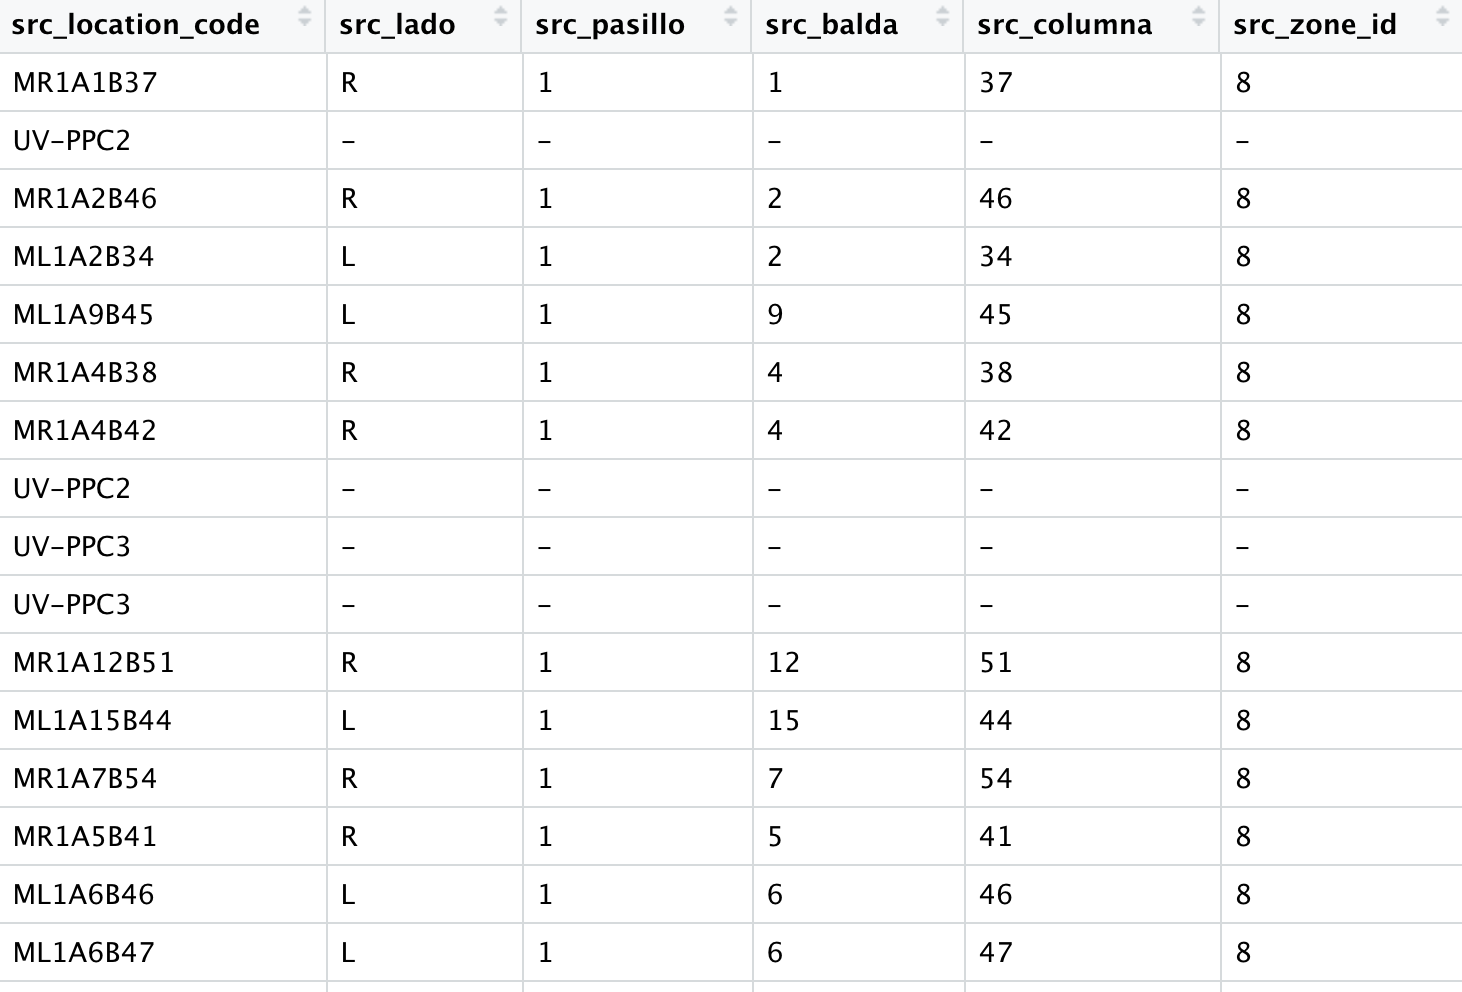